In [31]:
import os
from dotenv import load_dotenv, find_dotenv
from pydantic import BaseModel, Field
from enum import Enum, auto
from typing import List, Literal
from langchain_openai import ChatOpenAI
from langchain_deepseek import ChatDeepSeek
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from tools.agent_tools import tool_read_document, tool_write_document, tool_get_search_info, tool_search_results


_ = load_dotenv(find_dotenv())
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
SERPAPI_API_KEY = os.environ['SERPAPI_API_KEY']

THREAD_MEMORY = MemorySaver()
N_AGENTES = 3

available_tools = [tool_read_document, tool_write_document, tool_get_search_info, tool_search_results]


def create_dynamic_enum(values):
    return Enum('DynamicAgents', {f'{val}': val for val in values})



reasoning_model = ChatDeepSeek(model='deepseek-chat')
model = ChatOpenAI(model='gpt-4o')
reasoning_model = ChatOpenAI(model='gpt-4o')


class ResearchState(MessagesState):
    next : str
    instructions: str
    n_interactions: int
    agent_nodes : dict #dict containing role_agent as keys. Inside each item will have description and each interaction 
    current_instructions: str


class TeamMember(BaseModel):
    name: str = Field(description="Nombre de la persona del equipo")
    role: str = Field(description="Nombre del rol o puesto que ocupa en el proyecto")
    functions: str = Field(description="Descripción de las principales funciones de la persona y de sus especialidades que aportan al proyecto")
    

class InstructionNode(BaseModel):
    instructions: str = Field(description="Instrucciones precisas del trabajo que se debe entregar respecto a lo que solicita el usuario")
    team : List[TeamMember]





def node_get_instructions(state:ResearchState):
    sys_msg = f"""Eres un research manager encargado de dirigir un trabajo de investigación que elija el usuario. Tu principal objetivo es analizar lo que pide el usuario y 
    hacer un plan y objetivos sobre el trabajo que hay que entregar (un artículo por ejemplo). Devuelve una descripción detallada de como debe ser el entregable que se tiene que realizar y sobre todo una guía paso a paso de las tareas que se deben de ejecutar para llegar a cumplir.
    Una vez tengas detallado el trabajo que se tiene que entregar, tienes que pensar el equipo con el que vas a contar para realizar esta tarea. Ya cuentas asignado a un agente especializado en buscar información en internet.
    Deberás pensar en el resto del equipo con sus roles y funciones. El resto de agentes que tienes que pensar deben de ser {N_AGENTES}"""

    llm_with_structured_output = reasoning_model.with_structured_output(InstructionNode)
    result = llm_with_structured_output.invoke([SystemMessage(sys_msg)] + state['messages'])
    dict_agents = {}
    for t in result.team:
        dict_agents[t.role]= {'name': t.name, 'functions': t.functions}
    return {'messages': 'Objetivos establecidos y equipo asignado para realizar las tareas específicas', 'agent_nodes': dict_agents }


def node_manager_next_move(state:ResearchState):
    agents = list(state['agent_nodes'].keys())
    interacciones_restantes = state['n_interactions']
    class ManagerDecission(BaseModel):
        instructions: str = Field(description="Instrucciones precisas dirigidas a un miembro del equipo para que haga su parte de trabajo orientado a la consecución del objetivo final del proyecto. En caso de decidir que el trabajo está realizado devuelve en blanco")
        siguiente: str = Field(description=f"nombre del rol a quien se le dirige la instrución. En caso de considerarse terminado debe devolverse 'Closing'. En caso de ,mandar a un agente debe ser un valor literal \
                           entre los siguientes valores: {agents}")


    sys_msg = """Tu rol es ser manager del proyecto. Tu objetivo final es hacer lo mejor posible los objetivos establecidos por ti. Para ello debes tener en cuenta la conversación con el resto de miembros
    del equipo y la aportación dada por cada uno para decidir cual es el siguiente movimiento. Debes devolver unas instrucciones claras y el miembro del equipo que debe realizarlas. Puedes repetir el miembro del equipo si consideras
    que debe mejorar su aportación en algún punto. Debes de tener en cuenta también que hay un número máximo de interacciones, que serían las veces que puedes dar instrucciones a un miembro del equipo. Una vez queden 0 interacciones
     debería proceder a terminar el proyecto.
      
    Datos a tener en cuenta:
        interacciones restantes: {interacciones_restantes}""".format(
            interacciones_restantes = interacciones_restantes
        )

    llm_with_structured_output = model.with_structured_output(ManagerDecission)
    result = llm_with_structured_output.invoke([SystemMessage(sys_msg)] + state['messages'])
    node_message = f"""
                siguiente: {result.siguiente} \n
                instrucciones: {result.instructions}"""
    return  {'messages': node_message, 'current_instructions': result.instructions, 'next': result.siguiente}


# Multiagent Subgraph



def multiagent_node(state: ResearchState):
    current_agent = state['next']
    #agent_name = state.agent_nodes[current_agent]['name']
    agent_functions = state['agent_nodes'][current_agent]['functions']
    instructions = state['current_instructions']
    interactions = state['n_interactions']

    sys_message = """"Tu objetivo es hacer todo los que está en tu mano para cumplir como mejor puedas las instrucciones que has recibido de tu manager.
    Para ello puedes hacer uso de las herramientas aportadas en caso de ser necesario. Es importante que tengas en cuenta tu rol y funciones descritas a continuación.
    
    IMPORTANTE:
        detalles a tener en cuenta:
            Instrucciones del manager: {instructions}
            Tu rol o puesto de trabajo: {agent_role}
            Tus funciones y expertise: {agent_functions}""".format(
                instructions=instructions,
                agent_role=current_agent,
                agent_functions=agent_functions
            )

    llm_with_tools = model.bind_tools(tools=available_tools)
    result = llm_with_tools.invoke([SystemMessage(sys_message)]+ state['messages'])

    return {'messages': result, 'n_interactions': interactions - 1}

agent_workflow = StateGraph(ResearchState)
agent_workflow.add_node('agent', multiagent_node)
agent_workflow.add_node('tools', ToolNode(tools=available_tools))

agent_workflow.add_edge(START, 'agent')
agent_workflow.add_conditional_edges('agent', tools_condition)
agent_workflow.add_edge('tools', 'agent')

agent_subgraph = agent_workflow.compile(checkpointer=THREAD_MEMORY)


def router(state: ResearchState):
    next = state['next']
    if next == 'Closing':
        return 'Closing'
    else:
        return 'agent'
    
def node_closing(state: ResearchState):
    sys_msg = """Tu función  es devolver el trabajo en el mejor formato posible para que esté listo para publicar"""

    result = model.invoke([SystemMessage(sys_msg)] + state['messages'])

    return {'messages': result}


def init_values_node(state:ResearchState):
    if len(state['messages'])<2:
        return {'n_interactions': 10}
    return

builder = StateGraph(ResearchState)
builder.add_node('init_values', init_values_node)
builder.add_node('get_instructions', node_get_instructions)
builder.add_node('manager_move', node_manager_next_move)
builder.add_node('agent', agent_subgraph)
builder.add_node('Closing', node_closing)

builder.add_edge(START, 'init_values')
builder.add_edge('init_values', 'get_instructions')
builder.add_edge('get_instructions', 'manager_move')
builder.add_conditional_edges('manager_move', router, ['agent', 'Closing'])
builder.add_edge('agent', 'manager_move')
builder.add_edge('Closing', END)


graph = builder.compile(checkpointer=THREAD_MEMORY)








    


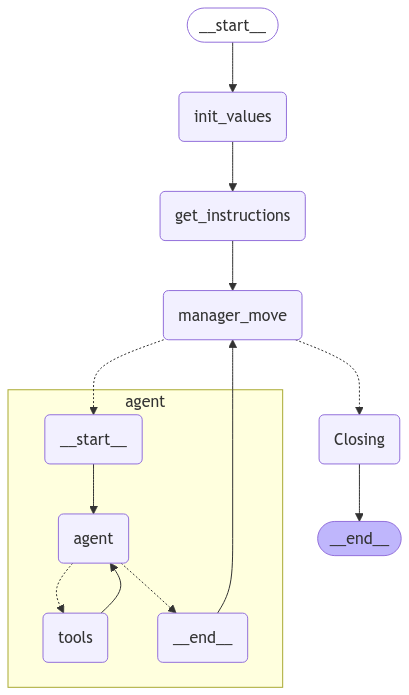

In [33]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [34]:
config ={ "configurable": {"thread_id": "2"}}
message = "quiero hacer una guía sobre la IA generativa con tutoriales para usuarios con conocimientos de infórmatica básicos para que puedan aprovechar esta tecnología en tareas cotidianas"
for event in graph.stream({"messages": message},config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

quiero hacer una guía sobre la IA generativa con tutoriales para usuarios con conocimientos de infórmatica básicos para que puedan aprovechar esta tecnología en tareas cotidianas
================================ Human Message =================================

quiero hacer una guía sobre la IA generativa con tutoriales para usuarios con conocimientos de infórmatica básicos para que puedan aprovechar esta tecnología en tareas cotidianas
================================ Human Message =================================

Objetivos establecidos y equipo asignado para realizar las tareas específicas
================================ Human Message =================================


                siguiente: Investigador de Información 

                instrucciones: 1. Investiga los conceptos fundamentales y elementos claves de la IA generativa que puedan ser enseñados a usuarios con conocimientos básicos de in

Task exception was never retrieved
future: <Task finished name='Task-62' coro=<Connection.run() done, defined at c:\Users\jarai\anaconda3\envs\llm\lib\site-packages\playwright\_impl\_connection.py:272> exception=NotImplementedError()>
Traceback (most recent call last):
  File "c:\Users\jarai\anaconda3\envs\llm\lib\site-packages\playwright\_impl\_connection.py", line 279, in run
    await self._transport.connect()
  File "c:\Users\jarai\anaconda3\envs\llm\lib\site-packages\playwright\_impl\_transport.py", line 133, in connect
    raise exc
  File "c:\Users\jarai\anaconda3\envs\llm\lib\site-packages\playwright\_impl\_transport.py", line 120, in connect
    self._proc = await asyncio.create_subprocess_exec(
  File "c:\Users\jarai\anaconda3\envs\llm\lib\asyncio\subprocess.py", line 218, in create_subprocess_exec
    transport, protocol = await loop.subprocess_exec(
  File "c:\Users\jarai\anaconda3\envs\llm\lib\asyncio\base_events.py", line 1681, in subprocess_exec
    transport = await sel

================================== Ai Message ==================================

Parece que hubo un problema al intentar recopilar información de los enlaces proporcionados. Dado esto, proporciono un resumen basado en mi conocimiento hasta la fecha:

### Conceptos Fundamentales de la IA Generativa
1. **Definición y Propósito:**
   - La IA generativa es una subsección de la inteligencia artificial enfocada en la generación de contenido nuevo, como texto, imágenes o música, basado en el aprendizaje de patrones a partir de datos existentes.

2. **Modelos Comunes:**
   - **GPT (Transformadores Generativos Preentrenados):** Usados para tareas de procesamiento de lenguaje natural como redacción de texto y respuesta a preguntas.
   - **GAN (Redes Generativas Antagónicas):** Utilizadas para generar imágenes nuevas y realistas.
   - **VAE (Autoencoders Variacionales):** Empleados en la creación de nuevas variaciones de imágenes u otros tipos de datos.

3. **Funcionamiento Básico:**
   - Basado